In [55]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [56]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [57]:
import os
import torch
from torch import nn
from torchvision.transforms import RandomAffine, Resize
import optuna


import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torchvision.transforms import RandomAffine, Resize

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    NormalMeshRenderer,
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)

from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [58]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [59]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [60]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [61]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((0.75 / float(scale)));

In [62]:
# cos_similarity = torch.nn.CosineSimilarity(dim=3)
# transform_range_horizontal = 100/1024
# transform_range_vertical = 100/1024
# transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical), fill=0.5)
# cos_similarity(mesh.normalmaps.maps_padded(), transform(mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1).squeeze().cpu().numpy()).mean()

In [63]:
# plt.figure(figsize=(7,7))
# texture_image=mesh.normalmaps.maps_padded()
# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix



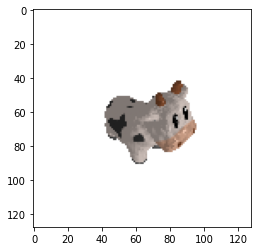

In [64]:
imsize = 128
# lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = 45
rand_azim = 135
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
TBN_matrices = tbn_matrices(mesh)
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)
random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
plt.imshow(random_target.cpu().numpy()[0])

In [65]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 30
batch_views = 1
imsize = 128
# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))
# elev = np.array([45, 45, 225, 225])
# azim = np.array([-45, 135, -45, 135])

def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 

normals_hook = torch.Tensor()
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)

# for i
# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_views)
target_rgb = []
target_cameras = []
target_normals = []
print()
# Render small batches of target views on GPU and append to list to be later converted to CPU tensor
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    target_images_batch, normals = renderer(meshes, cameras=cameras, lights=lights)

    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
    target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_rgb.extend(target_rgb_batch)
    target_cameras.extend(target_cameras_batch)
    target_normals.append(normals)


# 50/50 split of views for train/test
target_rgb, test_rgb = train_test_split(target_rgb)
target_cameras, test_cameras = train_test_split(target_cameras)
target_normals, test_normals = train_test_split(target_normals)

random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
print(len(target_rgb), len(target_cameras))


15 15


Visualize the dataset:

/tmp/ipykernel_924/1255958388.py:4: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/tmp/ipykernel_924/1255958388.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



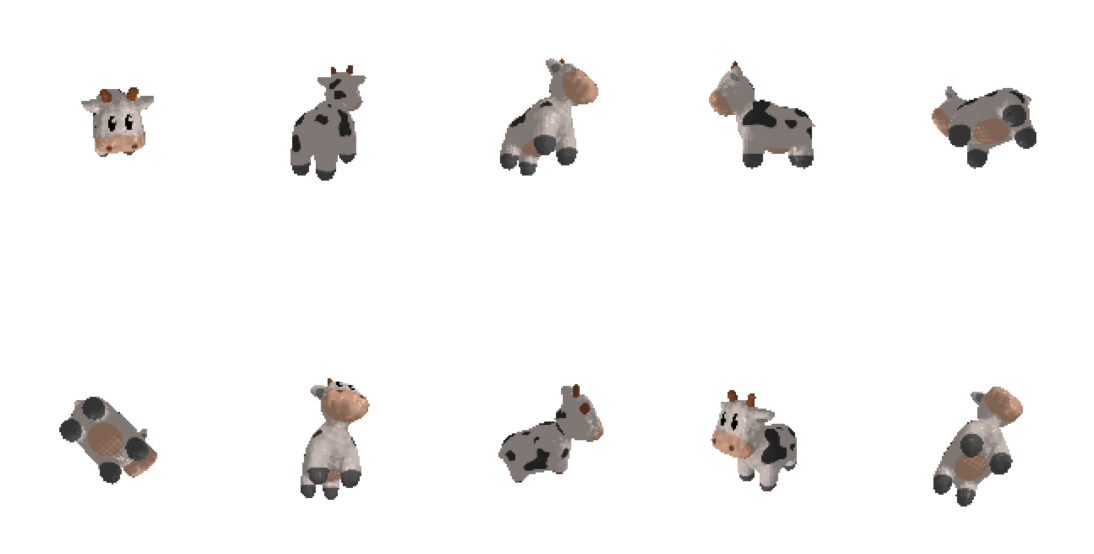

In [66]:
# RGB images
print()

image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

In [67]:
# # Rasterization settings for silhouette rendering  
# sigma = 1e-4
# raster_settings_silhouette = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
#     perspective_correct=False,
# )

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings_silhouette
#     ),
#     shader=SoftSilhouetteShader()
# )

# # # Render silhouette images.  The 3rd channel of the rendering output is 
# # # the alpha/silhouette channel
# # silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
# # print(silhouette_images.shape)
# # target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# # # Visualize silhouette images
# # image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# # plt.show()

/tmp/ipykernel_924/579964652.py:37: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/tmp/ipykernel_924/579964652.py:37: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/tmp/ipykernel_924/579964652.py:38: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struc

torch.Size([128, 128])


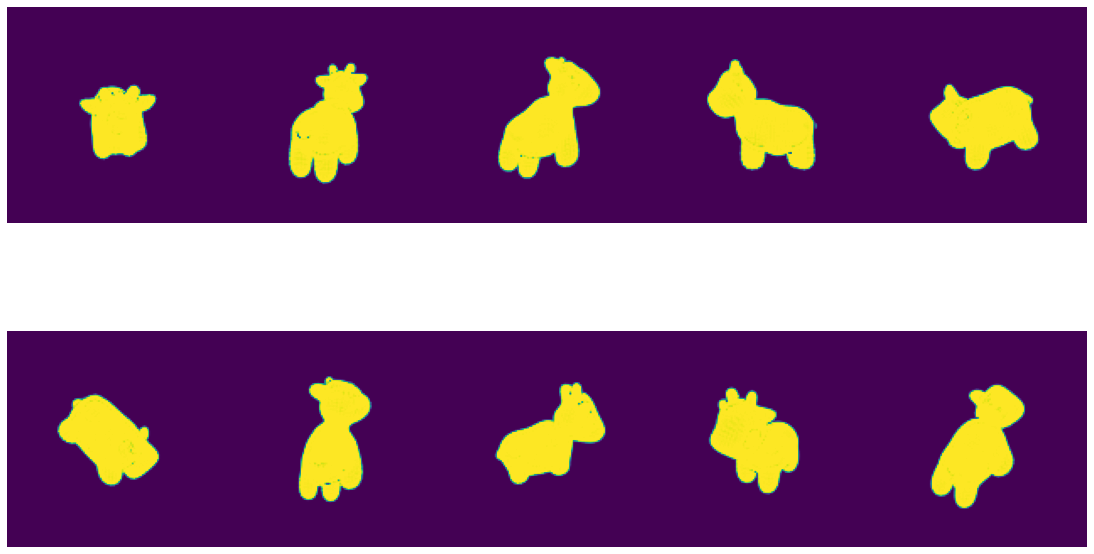

In [68]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
target_silhouette = []
silhouette_images = []
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    silhouette_images_batch = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    silhouette_images.extend(silhouette_images_batch.cpu())
    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_silhouette_batch = [silhouette_images_batch[i, ..., 3].cpu() for i in range(batch_views)]
    # target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                        #    T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_silhouette.extend(target_silhouette_batch)
    # target_cameras.extend(target_cameras_batch)
# Visualize silhouette images
print(np.asarray(target_silhouette[:10])[0].shape)
image_grid(np.asarray(silhouette_images[:10]), rows=2, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [69]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False, camera = camera):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images, _ = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [70]:
# We initialize the source shape to be a sphere of radius 1.  
silhouette_src_mesh = ico_sphere(4, device)
# src_mesh = mesh.clone()

torch.Size([2562]) torch.Size([2562])
torch.Size([2562, 2]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Target shapes faces: torch.Size([1, 5856, 3]), verts: torch.Size([1, 2930, 3])
Target shapes facesUVs: torch.Size([1, 5856, 3]), vertsUVs: torch.Size([1, 3225, 2])
torch.Size([2562, 3])


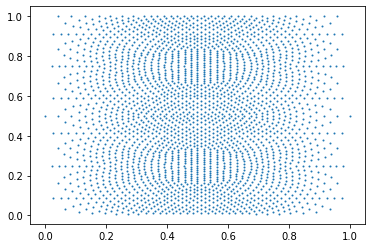

In [71]:
# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

# Creating UVs for sphere using equirectangular projection with scaled v axis
sphere_verts = silhouette_src_mesh.verts_packed()
xyz_to_u = torch.rad2deg(torch.arcsin(sphere_verts[:,2])) + 90
xyz_to_v = (torch.rad2deg(torch.atan2(sphere_verts[:,1], sphere_verts[:,0])) + 180) / 2 
print(xyz_to_u.shape, xyz_to_v.shape)
sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1) / 180
print(sphere_verts_uvs.shape, sphere_verts_uvs.max(), sphere_verts_uvs.min())
# need to solve seams somehow
# u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
# v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
# uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
print("Target shapes faces: {}, verts: {}".format(mesh.faces_padded().shape, mesh.verts_padded().shape, ))
print("Target shapes facesUVs: {}, vertsUVs: {}".format(mesh.textures.faces_uvs_padded().shape,  mesh.textures.verts_uvs_padded().shape))
print(silhouette_src_mesh.verts_packed().shape)
# silhouette_src_mesh.verts_padded().map
plt.scatter(sphere_verts_uvs.cpu()[:,0], sphere_verts_uvs.cpu()[:,1], s=1)
plt.show()
silhouette_src_mesh.textures = TexturesUV(mesh.textures.maps_padded(), faces_uvs=silhouette_src_mesh.faces_packed().unsqueeze(0), verts_uvs=sphere_verts_uvs.unsqueeze(0))

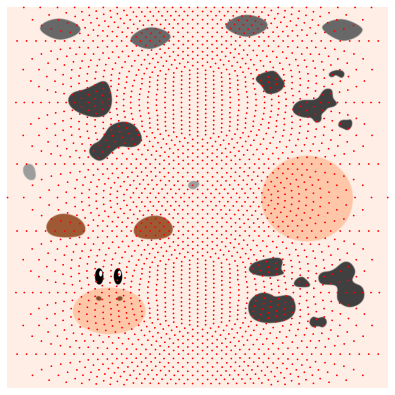

In [72]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=src_mesh.textures.maps_padded()
texturesuv_image_matplotlib(silhouette_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [73]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [74]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 5
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = silhouette_src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

In [75]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = silhouette_src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j].to(device)) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    # if i % plot_period == 0:
    #     visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
    #                          target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
# sum_loss=None
silhouette_result = new_src_mesh.clone().detach()
# visualize_prediction(silhouette_result, silhouette=True, 
#                      target_image=target_silhouette[1], camera=target_cameras[1])
# plot_losses(losses)

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [77]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019

new_TBN_matrices = tbn_matrices(silhouette_result)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=NormalSoftPhongShader(device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=new_TBN_matrices)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [78]:

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal", conv_layers = 4):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        scale_factor = max(8, 8*(2**(4-conv_layers)))
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear')
        self.normal_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )
        self.texture_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )

        if type == "normal":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                nn.Tanh(),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )
        elif type == "residual":
            self.generator =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )
        elif type == "simultaneous":
            modules = [nn.ConvTranspose2d(nz, ngf * (2**(conv_layers-1)), 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * (2**(conv_layers-1))),
                nn.ReLU(True)]

            # deconv layers that upscale by 2, maximum to 128x128
            for i in range(conv_layers - 1, max(conv_layers-4, 0), -1):
                modules.extend([
                nn.ConvTranspose2d(ngf * (2**(i)), ngf * (2**(i-1)), 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * (2**(i-1))),
                nn.ReLU(True)
                ])
            # convolution layers without upscaling beyond 128x128 to save on memory
            if conv_layers > 4:
                for j in range(conv_layers-4, 0, -1):
                    modules.extend([
                        nn.ConvTranspose2d(ngf * (2**(j)), ngf * (2**(j-1)), 3, 1, 1, bias=False),
                        nn.BatchNorm2d(ngf * (2**(j-1))),
                        nn.ReLU(True) 
                    ])

            self.generator = nn.Sequential(*modules)
    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)


In [79]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf = 32, nc = 3):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [80]:


%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
map_losses = {
          "rgb": {"weight": 1.0, "values": []},
        #   "silhouette": {"weight": 1.0, "values": []},
        #   "edge": {"weight": 1.0, "values": []},
        #   "normal": {"weight": 0.01, "values": []},
        #   "laplacian": {"weight": 1.0, "values": []},
          # "style": {"weight": 1.0, "values": []},
          # "adversarial": {"weight": 0.01, "values": []},
          "smoothness":{"weight":0.01, "values": []},
          "normal_smoothness":{"weight":0.01, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
# src_mesh = mesh.clone()
# verts_shape = src_mesh.verts_packed().shape
# deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# verts = src_mesh.verts_packed().to(device)
# .faces_packed().unsqueeze(dim=0).to(device)
faces_uvs = silhouette_result.textures.faces_uvs_padded()
uv_map = silhouette_result.textures.verts_uvs_padded()
# print(uv_map.shape, src_mesh.textures.verts_uvs_padded().shape)
# uv_map.requires_grad = True

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
# sphere_verts_rgb = torch.full(mesh.textures.maps_padded().shape, 0.1, device=device, requires_grad=True)
# sphere_verts_rgb = torch.normal(mean=torch.full(mesh.textures.maps_padded().shape, 0.5),std=0.05).to(device)
# sphere_verts_rgb.requires_grad = True
# print(sphere_verts_rgb)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)



In [81]:
def evaluate_model(eval_mesh):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )
        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = NormalMeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=new_TBN_matrices,
            )
        )
        test_cos_sim = torch.nn.CosineSimilarity(dim=4)
        normals_similarity = 0
        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted, normals_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
            normals_similarity += test_cos_sim(test_normals[j], normals_predicted).mean()
        mean_MSE = image_MSE / len(test_cameras)
        normals_similarity = normals_similarity / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE, normals_similarity
    # print(mean_MSE)

# print(evaluate_model())

In [82]:
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

In [83]:
import torch.utils.data
# from torchsummary import summary

def train_network(config):
    # Number of views to optimize over in each SGD iteration
    # print("Starting training")
    num_views_per_iteration = min(1, num_views)
    # Number of optimization steps
    Niter = 1000
    # Plot period for the losses
    plot_period = Niter // 5

    loop = tqdm(range(Niter))
    # maps = [sphere_verts_rgb.detach().cpu()]


    # Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    nc = 3
    # ndf = 32
    ngf = config["ngf"]
    nz = config["nz"]
    layers = config["layers"]
    lr = config["lr"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    l2penalty = config["l2"]
    amsgrad = config["amsgrad"]
    # print("Upacked parameters")


    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.05)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.05)
            nn.init.constant_(m.bias.data, 0)


    # Create discriminator for adversarial loss
    ngpu = 1
    # workers = 2
    # bce_loss = nn.BCELoss()
    # netD = Discriminator(ngpu, ndf).to(device)
    # netD.apply(weights_init)
    # real_label = 1.
    # fake_label = 0.
    # optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)


    # Create the generator
    netG = Generator(ngpu, ngf, nc, nz, "simultaneous", layers).to(device)
    # summary(netG, (nz, 1, 1))
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)

    # Need to create UV map for the sphere and optimize that together with the texture
    # The optimizer
    # maps_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces_uvs, verts_uvs=uv_map)

    # Need to create UV map for the sphere and optimize that together with the texture
    scale_factor = 1
    texture_size = list(mesh.textures.maps_padded().shape)
    texture_size[1] //= scale_factor
    texture_size[2] //= scale_factor

    # print("Texture Size: {}".format(texture_size))
    # sphere_verts_rgb = torch.zeros(texture_size, device=device, requires_grad=True)
    # optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)

    # sphere_verts_rgb = src_mesh.textures.maps_padded()
    # sphere_verts_rgb.requires_grad = True
    # The optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=l2penalty, amsgrad=amsgrad)
    random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
    # print(random_vector.shape)
    # print(random_vector.shape)
    # sphere_verts_rgb = netG(target_rgb[0].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1)
    sphere_verts_rgb, normal_map_base = netG(random_vector)
    # print(sphere_verts_rgb.shape, normal_map_base.shape)
    zero_dims = texture_size[:3]
    zero_dims.append(2)
    ones_dims = texture_size[:3]
    ones_dims.append(1)
    # begin with a flat normal map and just offset it using the generator by a small amount
    normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)
    # normal_map_base.requires_grad = True
    # optimizerNorm = torch.optim.Adam([normal_map_base], lr=lr, betas=(beta1, 0.999))


    maps_src_mesh = silhouette_result.clone()
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
    # print(maps_src_mesh.normalmaps.maps_padded().shape)

    # Cosine similarity loss for normal map
    cos_similarity = torch.nn.CosineSimilarity(dim=3)

    # print("Initialized state")


    # period to evaluate mesh against test views with normal rasterization
    eval_period = 20
    # mse_iters = []
    # cos_sims = []
    for i in loop:
        transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
        transform_range_vertical = 5/sphere_verts_rgb.shape[3]
        transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
        # Initialize optimizer
        optimizerG.zero_grad()
        
        # Deform the mesh
        # maps_src_mesh = src_mesh.offset_verts(deform_verts)
        
        # Add per vertex colors to texture the mesh
        # TODO create UV map for faces and vertices for the default sphere

        # sphere_verts_rgb = netG(target_rgb[i % len(target_rgb)].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) #- for generator network
        sphere_verts_rgb, normal_map_base = netG(random_vector)
        maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
        new_normal_map = normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat
        # new_normal_map = normal_map_flat
        maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

        # Losses to smooth /regularize the mesh shape
        map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
        # update_mesh_shape_prior_losses(maps_src_mesh, loss)
        # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        rendered_rgb = []

        # Getting examples from renderer as the Generator
        random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
        for j in random_views:
            images_predicted, _ = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted silhouette and the target 
            # # silhouette from our dataset
            # predicted_silhouette = images_predicted[..., 3]
            # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            # loss["silhouette"] += loss_silhouette / num_views_per_iteration
            
            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = images_predicted[..., :3]
            rendered_rgb.append(predicted_rgb.squeeze())
            loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()

            # Style loss WIP
            # target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0)
            # model, style_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0))
            # model_input = sphere_verts_rgb.clone().detach().to(device).permute(0,3,1,2)
            # model(model_input)
            # style_score = 0
            # for sl in style_losses:
            #     style_score += sl.loss

            # Shifted image to get the image to be smoother/gradient between pixels to be smoother
            smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
            normal_smoothness = cos_similarity(maps_src_mesh.normalmaps.maps_padded(), transform(maps_src_mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1)).mean()
            # print(normal_smoothness)

            map_loss["rgb"] += loss_rgb / num_views_per_iteration
            map_loss["smoothness"] += smoothness / num_views_per_iteration
            map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration
            # loss["style"] += style_score / num_views_per_iteration

        # ############################
        # # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # ###########################
        # ## Train with all-real batch
        # netD.zero_grad()
        # # Format batch
        # real_cpu = torch.stack([target_rgb[i].to(device) for i in random_views], dim=0).permute(0,3,1,2)
        # real_cpu = real_cpu + torch.randn(real_cpu.size(), device=device)*0.1
        # b_size = num_views_per_iteration
        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # # Forward pass real batch through D
        # output = netD(real_cpu).view(-1)
        # # Calculate loss on all-real batch
        # errD_real = bce_loss(output, label)
        # # Calculate gradients for D in backward pass
        # errD_real.backward()
        # # D_x = output.mean().item()

        # ## Train with all-fake batch
        # # Generate batch of latent vectors
        # # Generate fake image batch with G
        # fake = torch.stack(rendered_rgb, dim=0).permute(0,3,1,2) + torch.randn(real_cpu.size(), device=device)*0.1
        # label.fill_(fake_label)
        # # Classify all fake batch with D
        # output = netD(fake).view(-1)
        # # Calculate D's loss on the all-fake batch
        # errD_fake = bce_loss(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # errD_fake.backward(retain_graph=True)
        # # D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        # errD = errD_real + errD_fake
        # # Update D
        # optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        # label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        # errG = bce_loss(output, label)
        # # Calculate gradients for G
        # # D_G_z2 = output.mean().item()
        # # Update G

        # loss["adversarial"] = errG / num_views_per_iteration
        # loss_gan["generator"] = errG / num_views_per_iteration
        # loss_gan["discriminator"] = errD / num_views_per_iteration / 2

        # Weighted sum of the losses
        map_sum_loss = torch.tensor(0.0, device=device)
        for k, l in map_loss.items():
            map_sum_loss += l * map_losses[k]["weight"]
            map_losses[k]["values"].append(float(l.detach().cpu()))
        loop.set_description("total_loss = %.6f" % map_sum_loss)


        # for k, l in loss_gan.items():
            # losses_gan[k]["values"].append(float(l.detach().cpu()))
        # Print the losses
        
        # Plot mesh
        # if i % plot_period == 0:
        #     visualize_prediction(maps_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
            # maps.append(sphere_verts_rgb.detach().cpu())

        # Optimization step
        map_sum_loss.backward()
        optimizerG.step()

        
        if i % eval_period == 0:
            mse, cos_sim = evaluate_model(maps_src_mesh)
            # mse_iters.append(mse)
            # cos_sims.append(cos_sim)
            
        # Train Discriminator
        # I want to make a generator that will create patches from the texture and warp them somehow to simulate them being on a surface. I'm thinking of some gradient mask too so that we don't learn from empty space. 
        # The true examples would be patches from the real image (probably also good to make it so that the object makes up at least some proportion of the patch for it to be accepted)

        # Train Texture/Generator
        # Here I want to use the discriminator to learn the texture better to try and fool it with the renderer serving as generator and the texture being the parameters we are tweaking/learning. 
    # print("Finished training")
    mse, cos_sim = evaluate_model(maps_src_mesh)
    return mse



In [84]:
def objective(trial):

    params = {
            #   'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
            #   'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
            #   'n_unit': trial.suggest_int("n_unit", 4, 18)
                "ngf": trial.suggest_categorical('ngf', [16,32,64]),
                "nz": trial.suggest_int("nz", 10, 200),
                "layers": trial.suggest_int("layers", 2,5),
                "lr": trial.suggest_loguniform('lr', 1e-5, 1e-1),
                "beta1": trial.suggest_uniform('beta1', 0.2, 0.9),
                "beta2": trial.suggest_loguniform('beta2', 0.9, 0.9999),
                "l2": trial.suggest_loguniform('l2', 1e-6, 1e-2),
                "amsgrad": trial.suggest_categorical('amsgrad', [True,False]),
            }
    
    
    loss = train_network(params)

    return loss

In [85]:

# config = {
#     "ngf": tune.choice([16, 32, 64]),

# #     "nz": 100,
# #     "layers": tune.choice([2,3,4,5]),
# #     "lr": tune.loguniform(1e-5, 1e-1),
# #     "beta1": tune.uniform(0.2, 0.9),
# #     "beta2": 0.999,
# #     "l2": tune.loguniform(1e-6, 1e-2),
# #     "amsgrad": True,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": False,
# }
# scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         time_attr="training_iteration",
#         max_t=1000,
#         grace_period=1,
#         reduction_factor=2
#         )

# reporter = JupyterNotebookReporter(True,
#         metric_columns=["loss", "training_iteration"]
#         )


In [86]:
# custom_config = {
#     "ngf": 64,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": True,
# }
# train_network(custom_config)


In [87]:
# optuna optimization created following https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2022-03-21 00:27:35,386] A new study created in memory with name: no-name-92508461-33e6-44c5-bd5c-88150b753ded


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:28:53,247] Trial 0 finished with value: 0.003594357520341873 and parameters: {'ngf': 32, 'nz': 87, 'layers': 3, 'lr': 0.0005715626286533093, 'beta1': 0.3585904718224062, 'beta2': 0.9221610680846176, 'l2': 2.258816250907508e-06, 'amsgrad': False}. Best is trial 0 with value: 0.003594357520341873.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:30:10,719] Trial 1 finished with value: 0.003611976047977805 and parameters: {'ngf': 32, 'nz': 62, 'layers': 3, 'lr': 0.08682820112457242, 'beta1': 0.6859799051377495, 'beta2': 0.9286290102437573, 'l2': 2.6902543102509928e-06, 'amsgrad': True}. Best is trial 0 with value: 0.003594357520341873.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:31:33,865] Trial 2 finished with value: 0.003600777592509985 and parameters: {'ngf': 64, 'nz': 146, 'layers': 2, 'lr': 0.009444377114357864, 'beta1': 0.6293819698790448, 'beta2': 0.9070006531130104, 'l2': 0.0009616345420518262, 'amsgrad': False}. Best is trial 0 with value: 0.003594357520341873.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:32:48,713] Trial 3 finished with value: 0.003977199550718069 and parameters: {'ngf': 32, 'nz': 151, 'layers': 4, 'lr': 0.025105512008183718, 'beta1': 0.48445616925353285, 'beta2': 0.9543710208849677, 'l2': 0.00016017242962764703, 'amsgrad': False}. Best is trial 0 with value: 0.003594357520341873.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:34:08,880] Trial 4 finished with value: 0.02379225566983223 and parameters: {'ngf': 64, 'nz': 148, 'layers': 5, 'lr': 1.2198715288834462e-05, 'beta1': 0.833665253823815, 'beta2': 0.9378323833199816, 'l2': 0.007817274463139394, 'amsgrad': True}. Best is trial 0 with value: 0.003594357520341873.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:35:23,015] Trial 5 finished with value: 0.0029814683366566896 and parameters: {'ngf': 16, 'nz': 70, 'layers': 4, 'lr': 0.0007429904198916132, 'beta1': 0.5344414150831682, 'beta2': 0.9204984367840816, 'l2': 0.0003369415712640293, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:36:46,053] Trial 6 finished with value: 0.0037844236940145493 and parameters: {'ngf': 16, 'nz': 173, 'layers': 2, 'lr': 0.0003355962616040665, 'beta1': 0.6614147864268851, 'beta2': 0.9620608225963754, 'l2': 1.0623041862937838e-06, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:38:09,046] Trial 7 finished with value: 0.0035390877164900303 and parameters: {'ngf': 32, 'nz': 109, 'layers': 2, 'lr': 0.00024498496927604014, 'beta1': 0.8401684736292394, 'beta2': 0.9065689122306739, 'l2': 0.0003559350276073933, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:39:26,440] Trial 8 finished with value: 0.003591281594708562 and parameters: {'ngf': 16, 'nz': 191, 'layers': 3, 'lr': 0.04271741796495868, 'beta1': 0.5755487829378834, 'beta2': 0.9562602547299025, 'l2': 0.0009675045840528199, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:40:49,594] Trial 9 finished with value: 0.0035533872433006763 and parameters: {'ngf': 64, 'nz': 192, 'layers': 2, 'lr': 0.010262998326199842, 'beta1': 0.8177904094044417, 'beta2': 0.9000922841243004, 'l2': 0.00041341647012601917, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:42:04,365] Trial 10 finished with value: 0.011536046862602234 and parameters: {'ngf': 16, 'nz': 20, 'layers': 5, 'lr': 3.702849433351299e-05, 'beta1': 0.23746358761647124, 'beta2': 0.9927752647013495, 'l2': 2.448251860709829e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:43:19,087] Trial 11 finished with value: 0.003187931841239333 and parameters: {'ngf': 32, 'nz': 105, 'layers': 4, 'lr': 0.00013650347645900789, 'beta1': 0.46280733656430384, 'beta2': 0.9146727751368547, 'l2': 3.788573050396708e-05, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:44:33,104] Trial 12 finished with value: 0.003292193403467536 and parameters: {'ngf': 16, 'nz': 53, 'layers': 4, 'lr': 0.0021478992538600315, 'beta1': 0.44360364836365407, 'beta2': 0.9183714351873887, 'l2': 2.7164663735734024e-05, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:45:47,799] Trial 13 finished with value: 0.005001144949346781 and parameters: {'ngf': 32, 'nz': 112, 'layers': 4, 'lr': 8.46451825221737e-05, 'beta1': 0.3443387650311436, 'beta2': 0.9376133871296869, 'l2': 2.423702698517214e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:47:01,812] Trial 14 finished with value: 0.003434315789490938 and parameters: {'ngf': 16, 'nz': 83, 'layers': 4, 'lr': 0.001830304243889504, 'beta1': 0.4900568145286248, 'beta2': 0.9714573571356058, 'l2': 5.138405747038185e-05, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:48:16,586] Trial 15 finished with value: 0.01094723679125309 and parameters: {'ngf': 16, 'nz': 21, 'layers': 5, 'lr': 4.8259988295324464e-05, 'beta1': 0.37986880577091664, 'beta2': 0.9157366728571117, 'l2': 7.287147304906551e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:49:31,162] Trial 16 finished with value: 0.0034194495528936386 and parameters: {'ngf': 32, 'nz': 50, 'layers': 4, 'lr': 0.00015465308640534199, 'beta1': 0.25950885155252684, 'beta2': 0.9395592223643184, 'l2': 0.006173840604293008, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:50:48,499] Trial 17 finished with value: 0.003533497452735901 and parameters: {'ngf': 16, 'nz': 127, 'layers': 3, 'lr': 0.0010103257670901675, 'beta1': 0.7360270953258202, 'beta2': 0.9252575432011156, 'l2': 0.0001098643506494064, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:52:04,805] Trial 18 finished with value: 0.024662869051098824 and parameters: {'ngf': 32, 'nz': 86, 'layers': 5, 'lr': 1.3045587142032828e-05, 'beta1': 0.5781680313348522, 'beta2': 0.9092610567229872, 'l2': 0.0012205946301640607, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:53:20,855] Trial 19 finished with value: 0.0030743153765797615 and parameters: {'ngf': 64, 'nz': 72, 'layers': 4, 'lr': 0.0028434672712233104, 'beta1': 0.515675803593862, 'beta2': 0.9315368364687676, 'l2': 9.135552530166514e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:54:38,767] Trial 20 finished with value: 0.003464996349066496 and parameters: {'ngf': 64, 'nz': 41, 'layers': 3, 'lr': 0.004401994736165482, 'beta1': 0.754814600800381, 'beta2': 0.9726981155104556, 'l2': 7.31359305605879e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:55:55,005] Trial 21 finished with value: 0.0031252531334757805 and parameters: {'ngf': 64, 'nz': 92, 'layers': 4, 'lr': 0.0006634623364188811, 'beta1': 0.5196846896053275, 'beta2': 0.927953263389936, 'l2': 8.834287694789726e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:57:11,057] Trial 22 finished with value: 0.0032015929464250803 and parameters: {'ngf': 64, 'nz': 62, 'layers': 4, 'lr': 0.000904737857229503, 'beta1': 0.5410145962747335, 'beta2': 0.9313402973780687, 'l2': 8.588977325920559e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:58:27,368] Trial 23 finished with value: 0.00328590115532279 and parameters: {'ngf': 64, 'nz': 79, 'layers': 4, 'lr': 0.005248818110135085, 'beta1': 0.5403258878727248, 'beta2': 0.9452477343703866, 'l2': 1.0196747948589762e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 00:59:46,755] Trial 24 finished with value: 0.0037336370442062616 and parameters: {'ngf': 64, 'nz': 33, 'layers': 5, 'lr': 0.0020211517919971004, 'beta1': 0.40117071932374004, 'beta2': 0.9303544982648109, 'l2': 0.00020788988833950433, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:01:02,940] Trial 25 finished with value: 0.0032299195881932974 and parameters: {'ngf': 64, 'nz': 67, 'layers': 4, 'lr': 0.0006597546964645464, 'beta1': 0.6187961346894797, 'beta2': 0.9433942525115029, 'l2': 3.238320737323742e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:02:20,903] Trial 26 finished with value: 0.003513467963784933 and parameters: {'ngf': 64, 'nz': 99, 'layers': 3, 'lr': 0.00039987823140031595, 'beta1': 0.3126081399862608, 'beta2': 0.9333814143424255, 'l2': 0.002361333772025272, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:03:37,265] Trial 27 finished with value: 0.00334888300858438 and parameters: {'ngf': 64, 'nz': 128, 'layers': 4, 'lr': 0.0012776424663550703, 'beta1': 0.5204995755898456, 'beta2': 0.9230847442026316, 'l2': 6.996237601841979e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:04:56,829] Trial 28 finished with value: 0.003169152420014143 and parameters: {'ngf': 64, 'nz': 72, 'layers': 5, 'lr': 0.0034806646839548924, 'beta1': 0.43454466266267666, 'beta2': 0.9481287217736277, 'l2': 1.1505119682123564e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:06:10,877] Trial 29 finished with value: 0.003422937821596861 and parameters: {'ngf': 16, 'nz': 96, 'layers': 4, 'lr': 0.0005253474880524497, 'beta1': 0.6029276240599939, 'beta2': 0.9221890525927299, 'l2': 1.4602192889153382e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:07:28,734] Trial 30 finished with value: 0.003291683504357934 and parameters: {'ngf': 64, 'nz': 33, 'layers': 3, 'lr': 0.009914832784382965, 'beta1': 0.708195122885031, 'beta2': 0.9984525486301388, 'l2': 4.149484293754259e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:08:48,380] Trial 31 finished with value: 0.002999398158863187 and parameters: {'ngf': 64, 'nz': 73, 'layers': 5, 'lr': 0.003813723755545881, 'beta1': 0.42700950119533215, 'beta2': 0.9488901941117664, 'l2': 1.0276836187140071e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:10:08,065] Trial 32 finished with value: 0.0030704662203788757 and parameters: {'ngf': 64, 'nz': 74, 'layers': 5, 'lr': 0.0036744891170034915, 'beta1': 0.5129703824064621, 'beta2': 0.953748488584743, 'l2': 4.7146945943231545e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:11:27,614] Trial 33 finished with value: 0.0032989869359880686 and parameters: {'ngf': 64, 'nz': 54, 'layers': 5, 'lr': 0.0038266618363342647, 'beta1': 0.4133937101652785, 'beta2': 0.9683727552994572, 'l2': 2.0373137030246523e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:12:47,117] Trial 34 finished with value: 0.003390796948224306 and parameters: {'ngf': 64, 'nz': 75, 'layers': 5, 'lr': 0.02211632382259904, 'beta1': 0.3248453919771209, 'beta2': 0.9554243848488304, 'l2': 4.298275072058576e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:14:06,678] Trial 35 finished with value: 0.0033495735842734575 and parameters: {'ngf': 64, 'nz': 62, 'layers': 5, 'lr': 0.006956897645944004, 'beta1': 0.48397610550506176, 'beta2': 0.9813141579889896, 'l2': 1.507327097594308e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:15:26,024] Trial 36 finished with value: 0.003567533567547798 and parameters: {'ngf': 64, 'nz': 10, 'layers': 5, 'lr': 0.015854186140117247, 'beta1': 0.6760414618581845, 'beta2': 0.9505727742146295, 'l2': 0.00032493469440399245, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:16:40,950] Trial 37 finished with value: 0.003324439050629735 and parameters: {'ngf': 16, 'nz': 123, 'layers': 5, 'lr': 0.0026277920907286935, 'beta1': 0.5816137773866517, 'beta2': 0.9618995082222673, 'l2': 2.0981018840247087e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:18:00,603] Trial 38 finished with value: 0.0040596420876681805 and parameters: {'ngf': 64, 'nz': 75, 'layers': 5, 'lr': 0.08622561986359453, 'beta1': 0.48502368515742933, 'beta2': 0.9355376630212956, 'l2': 5.313017374724678e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:19:15,437] Trial 39 finished with value: 0.003537513315677643 and parameters: {'ngf': 16, 'nz': 40, 'layers': 5, 'lr': 0.0016363721871769676, 'beta1': 0.3870911166254209, 'beta2': 0.9626980346085076, 'l2': 0.0001008999983976316, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:20:31,682] Trial 40 finished with value: 0.003433185163885355 and parameters: {'ngf': 64, 'nz': 87, 'layers': 4, 'lr': 0.007214652216717845, 'beta1': 0.6473919937832725, 'beta2': 0.9492655019185555, 'l2': 0.0005790209479044302, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:21:47,776] Trial 41 finished with value: 0.0032345091458410025 and parameters: {'ngf': 64, 'nz': 91, 'layers': 4, 'lr': 0.0007537582197147934, 'beta1': 0.5134047225435476, 'beta2': 0.9417145390655715, 'l2': 1.8555765362468655e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:23:04,125] Trial 42 finished with value: 0.0031388727948069572 and parameters: {'ngf': 64, 'nz': 113, 'layers': 4, 'lr': 0.00029483877476888545, 'beta1': 0.5527361689338778, 'beta2': 0.9270350803708352, 'l2': 1.016718605942625e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:24:20,301] Trial 43 finished with value: 0.0031497697345912457 and parameters: {'ngf': 64, 'nz': 64, 'layers': 4, 'lr': 0.0032303716043654844, 'beta1': 0.8910536668544522, 'beta2': 0.9282057634685816, 'l2': 4.1005063096662496e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:25:38,295] Trial 44 finished with value: 0.0033188899978995323 and parameters: {'ngf': 64, 'nz': 100, 'layers': 3, 'lr': 0.0010963103093201523, 'beta1': 0.4519323900696414, 'beta2': 0.9122334454108807, 'l2': 1.5283992518135508e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:27:01,476] Trial 45 finished with value: 0.0036617438308894634 and parameters: {'ngf': 64, 'nz': 55, 'layers': 2, 'lr': 0.0004856086737211506, 'beta1': 0.508104635884911, 'beta2': 0.9191414751325748, 'l2': 2.7596142969681675e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:28:15,645] Trial 46 finished with value: 0.0035101997200399637 and parameters: {'ngf': 16, 'nz': 162, 'layers': 4, 'lr': 0.01569640221676232, 'beta1': 0.4188840646512107, 'beta2': 0.9022007227779206, 'l2': 0.0001960617459328806, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:29:31,784] Trial 47 finished with value: 0.0033703616354614496 and parameters: {'ngf': 32, 'nz': 81, 'layers': 5, 'lr': 0.0002697836039494978, 'beta1': 0.46808937516940646, 'beta2': 0.9373195349310639, 'l2': 5.512294957992086e-06, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:30:45,774] Trial 48 finished with value: 0.0036333054304122925 and parameters: {'ngf': 16, 'nz': 69, 'layers': 4, 'lr': 0.0014446481996297142, 'beta1': 0.5989043130040715, 'beta2': 0.9596255231758584, 'l2': 6.473912810491901e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:32:01,817] Trial 49 finished with value: 0.0033481833525002003 and parameters: {'ngf': 64, 'nz': 93, 'layers': 4, 'lr': 0.005174300290730726, 'beta1': 0.5577362788300065, 'beta2': 0.953887309621092, 'l2': 2.987981536990826e-05, 'amsgrad': False}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:33:18,309] Trial 50 finished with value: 0.0033143735490739346 and parameters: {'ngf': 32, 'nz': 116, 'layers': 5, 'lr': 0.00017942883939592506, 'beta1': 0.6323570990712934, 'beta2': 0.9054146453004625, 'l2': 1.2028831247466541e-05, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:34:34,932] Trial 51 finished with value: 0.003849779022857547 and parameters: {'ngf': 64, 'nz': 140, 'layers': 4, 'lr': 8.964810555419785e-05, 'beta1': 0.5473158291094574, 'beta2': 0.9250639288388163, 'l2': 1.9599875988852943e-06, 'amsgrad': True}. Best is trial 5 with value: 0.0029814683366566896.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:35:51,392] Trial 52 finished with value: 0.0029660393483936787 and parameters: {'ngf': 64, 'nz': 103, 'layers': 4, 'lr': 0.002471009957906173, 'beta1': 0.5188507539780817, 'beta2': 0.9269928400467576, 'l2': 1.0685505489322722e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:37:07,682] Trial 53 finished with value: 0.0031864994671195745 and parameters: {'ngf': 64, 'nz': 106, 'layers': 4, 'lr': 0.0026197120077246223, 'beta1': 0.5130686084386719, 'beta2': 0.9181568389785951, 'l2': 6.1281190360645505e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:38:23,918] Trial 54 finished with value: 0.003107530064880848 and parameters: {'ngf': 64, 'nz': 84, 'layers': 4, 'lr': 0.002070558869575747, 'beta1': 0.45495323741098276, 'beta2': 0.9334119549974007, 'l2': 1.5235562210008977e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:39:41,871] Trial 55 finished with value: 0.0032460349611938 and parameters: {'ngf': 64, 'nz': 47, 'layers': 3, 'lr': 0.0068557457688181046, 'beta1': 0.37040298038087, 'beta2': 0.9333984962987583, 'l2': 1.43943192736355e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:40:55,948] Trial 56 finished with value: 0.0032988020684570074 and parameters: {'ngf': 16, 'nz': 82, 'layers': 4, 'lr': 0.002319523517142145, 'beta1': 0.4389683556853756, 'beta2': 0.9464110276432918, 'l2': 1.2880637187392555e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:42:15,161] Trial 57 finished with value: 0.0035128998570144176 and parameters: {'ngf': 64, 'nz': 62, 'layers': 5, 'lr': 0.01277469893897301, 'beta1': 0.279385077607154, 'beta2': 0.9413890473185157, 'l2': 3.4673693263444014e-06, 'amsgrad': False}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:43:31,516] Trial 58 finished with value: 0.0031520752236247063 and parameters: {'ngf': 64, 'nz': 103, 'layers': 4, 'lr': 0.0016646278474186477, 'beta1': 0.46515628600599984, 'beta2': 0.9126913450121737, 'l2': 2.411764819784733e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:44:46,228] Trial 59 finished with value: 0.0032309081871062517 and parameters: {'ngf': 32, 'nz': 76, 'layers': 4, 'lr': 0.0009865600842955775, 'beta1': 0.49125293491566097, 'beta2': 0.9513008614523467, 'l2': 0.0016508935915094053, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:46:03,538] Trial 60 finished with value: 0.0032520988024771214 and parameters: {'ngf': 16, 'nz': 88, 'layers': 3, 'lr': 0.005146125436783822, 'beta1': 0.3522576073887633, 'beta2': 0.9194542546238699, 'l2': 0.0005057604451880037, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:47:19,827] Trial 61 finished with value: 0.0030057141557335854 and parameters: {'ngf': 64, 'nz': 94, 'layers': 4, 'lr': 0.0007017308428369388, 'beta1': 0.528513552766742, 'beta2': 0.9295551330561307, 'l2': 1.6941419795000943e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:48:35,946] Trial 62 finished with value: 0.0032417161855846643 and parameters: {'ngf': 64, 'nz': 69, 'layers': 4, 'lr': 0.002852079531870075, 'beta1': 0.5659940308481821, 'beta2': 0.9313645289404041, 'l2': 1.031679098947315e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:49:52,294] Trial 63 finished with value: 0.0031879073940217495 and parameters: {'ngf': 64, 'nz': 119, 'layers': 4, 'lr': 0.0019566056794373967, 'beta1': 0.5312646040805247, 'beta2': 0.9362515837107203, 'l2': 1.619790286159244e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:51:08,365] Trial 64 finished with value: 0.003094143234193325 and parameters: {'ngf': 64, 'nz': 59, 'layers': 4, 'lr': 0.0013597889796116561, 'beta1': 0.4282372068781548, 'beta2': 0.9241486923377956, 'l2': 3.3975243745560714e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:52:24,343] Trial 65 finished with value: 0.00324104237370193 and parameters: {'ngf': 64, 'nz': 59, 'layers': 4, 'lr': 0.0003966844458921162, 'beta1': 0.4252543191428932, 'beta2': 0.9239158129436219, 'l2': 4.004268233839459e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:53:43,672] Trial 66 finished with value: 0.0032955450005829334 and parameters: {'ngf': 64, 'nz': 45, 'layers': 5, 'lr': 0.0013020911653030358, 'beta1': 0.2039211797096302, 'beta2': 0.9215092053216041, 'l2': 2.611144082878666e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:55:06,749] Trial 67 finished with value: 0.003502369625493884 and parameters: {'ngf': 64, 'nz': 57, 'layers': 2, 'lr': 0.0008349122218526743, 'beta1': 0.4005534650342563, 'beta2': 0.9096517732895306, 'l2': 7.412984315889562e-06, 'amsgrad': False}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:56:23,405] Trial 68 finished with value: 0.003266365500167012 and parameters: {'ngf': 64, 'nz': 184, 'layers': 4, 'lr': 0.0038913575131656387, 'beta1': 0.5940495922978308, 'beta2': 0.9401771427059686, 'l2': 5.148444910974061e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:57:38,226] Trial 69 finished with value: 0.0033621315378695726 and parameters: {'ngf': 16, 'nz': 71, 'layers': 5, 'lr': 0.000524551947196461, 'beta1': 0.49364249571426194, 'beta2': 0.9160856964920098, 'l2': 3.0056612062958703e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 01:58:56,146] Trial 70 finished with value: 0.0036310527939349413 and parameters: {'ngf': 64, 'nz': 79, 'layers': 3, 'lr': 0.001438580944800892, 'beta1': 0.5323802205964704, 'beta2': 0.9438715056716571, 'l2': 0.00029822495889181495, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:00:12,453] Trial 71 finished with value: 0.003054284956306219 and parameters: {'ngf': 64, 'nz': 86, 'layers': 4, 'lr': 0.0019918752771743804, 'beta1': 0.46134599144598554, 'beta2': 0.930012839070488, 'l2': 1.6896105828213784e-06, 'amsgrad': True}. Best is trial 52 with value: 0.0029660393483936787.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:01:28,723] Trial 72 finished with value: 0.0029653108213096857 and parameters: {'ngf': 64, 'nz': 96, 'layers': 4, 'lr': 0.007832076219093069, 'beta1': 0.4703118969186936, 'beta2': 0.929212680919592, 'l2': 1.9902375671918932e-06, 'amsgrad': True}. Best is trial 72 with value: 0.0029653108213096857.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:02:44,950] Trial 73 finished with value: 0.0030152772087603807 and parameters: {'ngf': 64, 'nz': 95, 'layers': 4, 'lr': 0.008765925320431526, 'beta1': 0.49947309124868133, 'beta2': 0.9284575677442755, 'l2': 1.8055621030523293e-06, 'amsgrad': True}. Best is trial 72 with value: 0.0029653108213096857.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:04:01,256] Trial 74 finished with value: 0.0029629573691636324 and parameters: {'ngf': 64, 'nz': 98, 'layers': 4, 'lr': 0.007670322643086698, 'beta1': 0.47469913669995156, 'beta2': 0.929241529950142, 'l2': 1.9541846644896068e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:05:17,715] Trial 75 finished with value: 0.0029741497710347176 and parameters: {'ngf': 64, 'nz': 109, 'layers': 4, 'lr': 0.008035238147299673, 'beta1': 0.4706351979972784, 'beta2': 0.921102866759362, 'l2': 1.7936301669603247e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:06:34,059] Trial 76 finished with value: 0.003042275784537196 and parameters: {'ngf': 64, 'nz': 110, 'layers': 4, 'lr': 0.007536537777889589, 'beta1': 0.4743260003813615, 'beta2': 0.9270715080406358, 'l2': 1.2850097490021342e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:07:50,511] Trial 77 finished with value: 0.0032336506992578506 and parameters: {'ngf': 64, 'nz': 136, 'layers': 4, 'lr': 0.03126815057547447, 'beta1': 0.48960663628243434, 'beta2': 0.9212717877410479, 'l2': 2.0653636652643454e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:09:05,235] Trial 78 finished with value: 0.003129195421934128 and parameters: {'ngf': 32, 'nz': 98, 'layers': 4, 'lr': 0.011348690148389613, 'beta1': 0.5777436705455553, 'beta2': 0.9156788752409678, 'l2': 1.2090789648835989e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:10:21,525] Trial 79 finished with value: 0.0036555372644215822 and parameters: {'ngf': 64, 'nz': 95, 'layers': 4, 'lr': 0.020009056474209704, 'beta1': 0.4048099842162281, 'beta2': 0.927306621607693, 'l2': 0.00362396443095447, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:11:35,550] Trial 80 finished with value: 0.0031792798545211554 and parameters: {'ngf': 16, 'nz': 108, 'layers': 4, 'lr': 0.008284628939318753, 'beta1': 0.5017659443305181, 'beta2': 0.9352358802257873, 'l2': 1.8170541415927445e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:12:51,901] Trial 81 finished with value: 0.003223195904865861 and parameters: {'ngf': 64, 'nz': 123, 'layers': 4, 'lr': 0.006247707410757982, 'beta1': 0.47051630931213534, 'beta2': 0.9262200209913343, 'l2': 0.00013961223228807642, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:14:08,065] Trial 82 finished with value: 0.003118524793535471 and parameters: {'ngf': 64, 'nz': 112, 'layers': 4, 'lr': 0.009044822603767827, 'beta1': 0.4761361298274451, 'beta2': 0.928669357665689, 'l2': 1.0476567901419984e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:15:24,278] Trial 83 finished with value: 0.0029692428652197123 and parameters: {'ngf': 64, 'nz': 104, 'layers': 4, 'lr': 0.004556397362274306, 'beta1': 0.443790504691365, 'beta2': 0.9224969782379276, 'l2': 2.436689356945912e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:16:40,558] Trial 84 finished with value: 0.0032126642763614655 and parameters: {'ngf': 64, 'nz': 99, 'layers': 4, 'lr': 0.004640947388532658, 'beta1': 0.4450061218435585, 'beta2': 0.9198698714968429, 'l2': 2.4652916615021983e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:17:56,840] Trial 85 finished with value: 0.002993231173604727 and parameters: {'ngf': 64, 'nz': 103, 'layers': 4, 'lr': 0.015104059667315177, 'beta1': 0.538054949405586, 'beta2': 0.9229255486028967, 'l2': 3.6979059825919525e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:19:12,981] Trial 86 finished with value: 0.003547429572790861 and parameters: {'ngf': 64, 'nz': 103, 'layers': 4, 'lr': 0.030143919542684004, 'beta1': 0.536020854192352, 'beta2': 0.9127901487216828, 'l2': 3.5715938284817787e-06, 'amsgrad': False}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:20:29,367] Trial 87 finished with value: 0.00335173262283206 and parameters: {'ngf': 64, 'nz': 130, 'layers': 4, 'lr': 0.013011504017930494, 'beta1': 0.38953796114673184, 'beta2': 0.9231445602355677, 'l2': 0.0008214227861902477, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:21:47,237] Trial 88 finished with value: 0.003390202997252345 and parameters: {'ngf': 64, 'nz': 90, 'layers': 3, 'lr': 0.01696135737453379, 'beta1': 0.5562251233707506, 'beta2': 0.9178293666865418, 'l2': 2.6780133235306803e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:23:03,540] Trial 89 finished with value: 0.0034595585893839598 and parameters: {'ngf': 64, 'nz': 118, 'layers': 4, 'lr': 0.056363740605210814, 'beta1': 0.43905051213362484, 'beta2': 0.9099771432270636, 'l2': 2.2339127223760366e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:24:17,424] Trial 90 finished with value: 0.0032558238599449396 and parameters: {'ngf': 16, 'nz': 107, 'layers': 4, 'lr': 0.010588481805931476, 'beta1': 0.6135458744723974, 'beta2': 0.9315039313580521, 'l2': 6.5654848886305e-06, 'amsgrad': True}. Best is trial 74 with value: 0.0029629573691636324.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:25:33,633] Trial 91 finished with value: 0.0029400924686342478 and parameters: {'ngf': 64, 'nz': 94, 'layers': 4, 'lr': 0.005425492476777124, 'beta1': 0.5076397726936703, 'beta2': 0.9214742796191817, 'l2': 1.698130190537183e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:26:49,974] Trial 92 finished with value: 0.002978673204779625 and parameters: {'ngf': 64, 'nz': 102, 'layers': 4, 'lr': 0.0055469248028207, 'beta1': 0.5288327814655176, 'beta2': 0.9216819187229374, 'l2': 1.3157648190464387e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:28:06,328] Trial 93 finished with value: 0.0031734684016555548 and parameters: {'ngf': 64, 'nz': 101, 'layers': 4, 'lr': 0.0062950169392407985, 'beta1': 0.5194199946746292, 'beta2': 0.9145133370050158, 'l2': 1.2423637008170393e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:29:22,792] Trial 94 finished with value: 0.0031267039012163877 and parameters: {'ngf': 64, 'nz': 113, 'layers': 4, 'lr': 0.0032237439918586996, 'beta1': 0.5687219653875598, 'beta2': 0.9213884117061109, 'l2': 4.479429113496509e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:30:39,254] Trial 95 finished with value: 0.003167522605508566 and parameters: {'ngf': 64, 'nz': 105, 'layers': 4, 'lr': 0.005698023494370791, 'beta1': 0.37210304421573437, 'beta2': 0.9176243212569949, 'l2': 1.401929345509859e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:31:55,329] Trial 96 finished with value: 0.0032068551518023014 and parameters: {'ngf': 64, 'nz': 90, 'layers': 4, 'lr': 0.004286483848659528, 'beta1': 0.4526711799484167, 'beta2': 0.9253174481474229, 'l2': 3.0642616403712035e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:33:10,112] Trial 97 finished with value: 0.0030373316258192062 and parameters: {'ngf': 32, 'nz': 115, 'layers': 4, 'lr': 0.01212844045121623, 'beta1': 0.5435111885695504, 'beta2': 0.9228854820647258, 'l2': 2.227239007281144e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:34:26,466] Trial 98 finished with value: 0.003495135111734271 and parameters: {'ngf': 64, 'nz': 122, 'layers': 4, 'lr': 0.015234952452894017, 'beta1': 0.5068137364057428, 'beta2': 0.9383967245098488, 'l2': 1.1720334736907157e-06, 'amsgrad': True}. Best is trial 91 with value: 0.0029400924686342478.


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning:

R is not a valid rotation matrix

[I 2022-03-21 02:35:42,781] Trial 99 finished with value: 0.0031999184284359217 and parameters: {'ngf': 64, 'nz': 109, 'layers': 4, 'lr': 0.004805657974204409, 'beta1': 0.589462410769616, 'beta2': 0.920642152956234, 'l2': 1.5114899229725337e-06, 'amsgrad': False}. Best is trial 91 with value: 0.0029400924686342478.


In [94]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("\"{}\": {},".format(key, value))

# RGB only
# "ngf": 64,
# "nz": 94,
# "layers": 4,
# "lr": 0.005425492476777124,
# "beta1": 0.5076397726936703,
# "beta2": 0.9214742796191817,
# "l2": 1.698130190537183e-06,
# "amsgrad": True,

# RGB and cos sim optimization
# "ngf": 64
# "n_unit": 167
# "layers": 2
# "lr": 0.04165803794830159
# "beta1": 0.7482115163186268
# "beta2": 0.9595019689796743
# "l2": 0.0023515772552477328
# "amsgrad": True

"ngf": 64,
"nz": 94,
"layers": 4,
"lr": 0.005425492476777124,
"beta1": 0.5076397726936703,
"beta2": 0.9214742796191817,
"l2": 1.698130190537183e-06,
"amsgrad": True,


In [89]:
optuna.visualization.plot_intermediate_values(study)


[W 2022-03-21 02:35:42,989] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [90]:
optuna.visualization.plot_optimization_history(study)


In [91]:
optuna.visualization.plot_parallel_coordinate(study)


In [93]:
# import sklearn
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'sklearn' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'sklearn'.

In [ ]:
# from itertools import product
# dimensions = torch.tensor(list(sphere_verts_rgb.grad.shape))
# print("Total dimension of gradient: {}\nNonzero dimension of gradient: {}".format(torch.prod(dimensions), sphere_verts_rgb.grad.count_nonzero()))
# plt.figure(figsize=(7,7))
# # from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=sphere_verts_rgb.grad*10000000*10

# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())

In [ ]:
# plt.hist(netG.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plt.hist(normal_map_base.grad.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plot_losses(losses_gan)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False, camera=target_cameras[0], target_image=target_rgb[0])
# plot_losses(losses)

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=maps_src_mesh.textures.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# # texture_image=new_src_mesh.normalmaps.maps_padded()

# texture_image=maps_src_mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

Save the final predicted mesh:

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(mesh.textures, subsample=None)
# # print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# # print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.